A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflects in the data.

#### libraries import

In [201]:
%matplotlib inline
%load_ext memory_profiler

import numpy as np
import pandas as pd

import scipy.cluster.hierarchy as shc
from scipy.cluster import hierarchy

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
from yellowbrick.style import rcmod


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## VISUALIZATION

In [2]:
X = np.load('X.npy')

In [3]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,45758,45759,45760,45761,45762,45763,45764,45765,45766,45767
0,0.0,0.0,133.855304,164.894216,0.000000,24.249149,3.879864,0.0,93.116733,64.017754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,60.255141,97.772493,3.410668,0.000000,1.136889,0.0,28.422236,36.380462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,129.614628,149.288277,0.000000,19.673649,0.000000,0.0,20.830922,79.851869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,100.392193,117.439923,0.000000,45.460615,0.000000,0.0,0.000000,161.006346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,78.890168,191.926828,0.000000,10.597187,12.952117,0.0,43.566212,25.904234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,0.0,0.0,45.979776,136.170875,0.000000,19.452982,0.000000,0.0,130.865516,107.875628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,106.380149,87.383694,0.000000,0.000000,0.000000,0.0,93.082631,36.093265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508,0.0,0.0,137.400940,70.721072,0.000000,26.267827,0.000000,0.0,236.410441,115.174317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
509,0.0,0.0,174.766448,111.215013,0.000000,13.618165,0.000000,0.0,24.966635,45.393883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('# cells', X.shape[0], '  |  ',  '# features:', X.shape[1])

# cells 511   |   # features: 45768


Due to the presence of genes with extremely high magnitudes of expression in only a few cells, it is common to apply a log-transform to the data. So, th first step is to transform original data to in order to fit the scale of values by applying logarithmic function:

In [5]:
X_log = np.log2(X + 1) #log transformation (treating outliers)

## Exploring the number of clusters

<b>Principle Component Analysis </b>

In [6]:
def do_pca(data, n_components=None):
    pca = PCA(n_components)
    x = pca.fit_transform(data)
    return pca, x

Once the data has been transformed, we apply the PCA dimesionality reduction techique, and visualize the first two components, which are those that explain most of the variability in the data. PCA projects data in the diractions of maximum variance space, magnifying the differences between genes experssion of the different cell types that exist. Thus, similar expression implies small distances and different expression implies large differences.

In [7]:
pca2, x2 = do_pca(X, 2)

In [8]:
%%timeit -n 1 -r 1
%%memit -r 1
pca, x_pc = do_pca(X) 
pca_log, x_log_pc = do_pca(X_log) 

peak memory: 1307.91 MiB, increment: 786.16 MiB
36.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


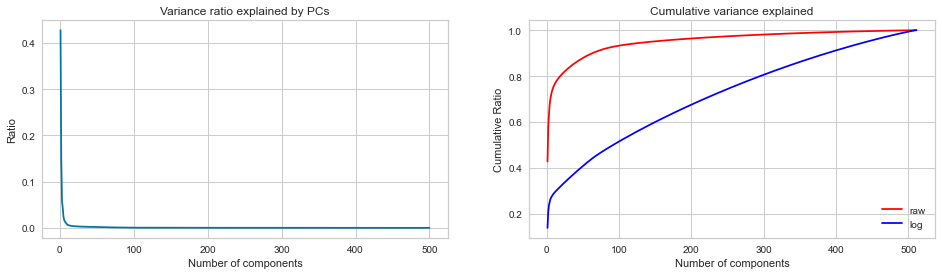

Variance explained by 2 components: 0.576


In [9]:
figure = plt.figure(figsize=(16, 4))

plt.subplot2grid((1, 2),(0,0))
plt.plot(np.arange(1, 501), pca.explained_variance_ratio_[0:500])
plt.title('Variance ratio explained by PCs')
plt.xlabel('Number of components')
plt.ylabel('Ratio')

plt.subplot2grid((1, 2),(0,1))
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.title('Cumulative variance explained')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Ratio')
plt.legend()
plt.show()

e2 = np.sum(pca2.explained_variance_ratio_)
print('Variance explained by 2 components:', round(e2, 3))

In [10]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


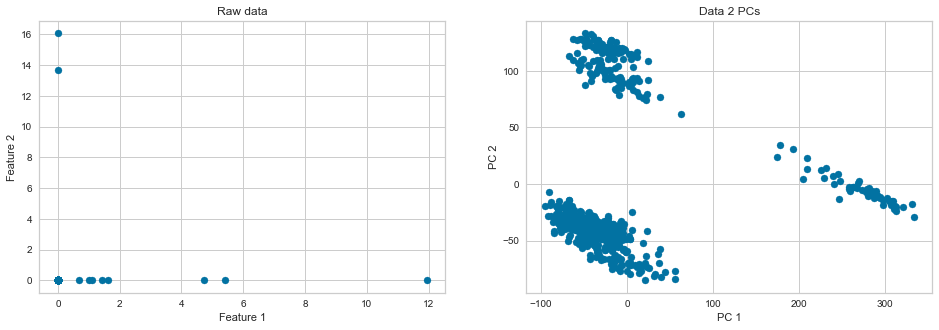

In [11]:
figure = plt.figure(figsize=(16, 5))
plt.subplot2grid((1, 2),(0,0))
plt.scatter(X[:, 0], X[:, 1])
plt.title('Without Visualization Technique')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot2grid((1, 2),(0,1))
plt.scatter(x_log_pc[:, 0], x_log_pc[:, 1])
plt.title('After PCA transformation')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Nothing informative on the first picture and clearly seen three distinct clusters on the second one.

<b>MDS</b>

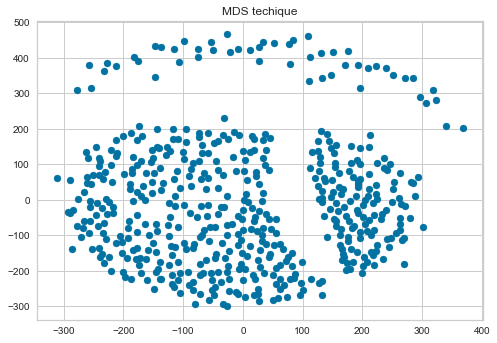

In [35]:
mds_model = MDS(n_components=2, verbose=1, eps=10e-5)
mds_model.fit_transform(X_log)
plt.scatter(mds_model.embedding_[:, 0], mds_model.embedding_[:, 1])
plt.title('MDS techique')
plt.show()

There are still trhee distinct clusters on the chart

<b> t-SNE <b>

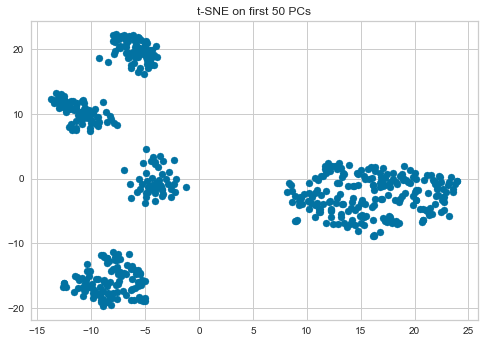

In [13]:
tsne = TSNE(perplexity=50)
z_tsne = tsne.fit_transform(x_log_pc[:, :50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])
plt.title('t-SNE on first 50 PCs')
plt.show()

The picture shows emergence of at least 5 clusters.

<b>Elbow method </b>

In [14]:
all_models = [KMeans(n_clusters=i, n_init=100) for i in range(1, 9)]

In [15]:
for i in range(8):
    all_models[i].fit(x_log_pc)

Text(0.5, 1.0, 'Elbow plot')

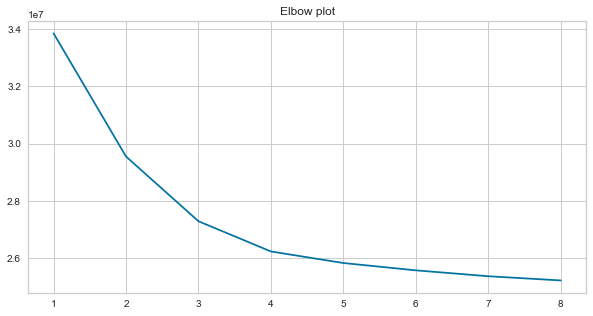

In [34]:
inertias = [all_models[i].inertia_ for i in range(8)]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 9), inertias)
plt.title('Elbow plot')

Would select 3, 4, or 5 clusters

<b> K-Means </b>

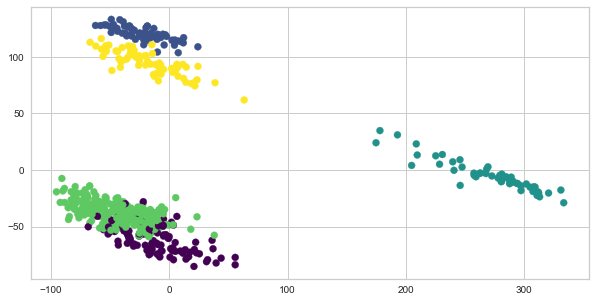

In [29]:
plt.figure(figsize=(10, 5))
kmeans = KMeans(n_clusters=5)
kmeans.fit(x_log_pc[:,0:50])
plt.scatter(x_log_pc[:,0],x_log_pc[:,1], c=kmeans.labels_, cmap='viridis')
plt.show()

Text(0.5, 1.0, 'KMeans on MDS')

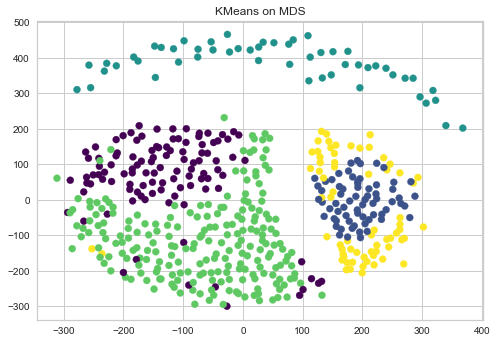

In [38]:
# 5 clusters: MDA with K means plot
plt.scatter(mds_model.embedding_[:,0], mds_model.embedding_[:,1],c=kmeans.labels_, cmap='viridis')
plt.title('KMeans on MDS')

Text(0.5, 1.0, 'KMeans on t-SNE')

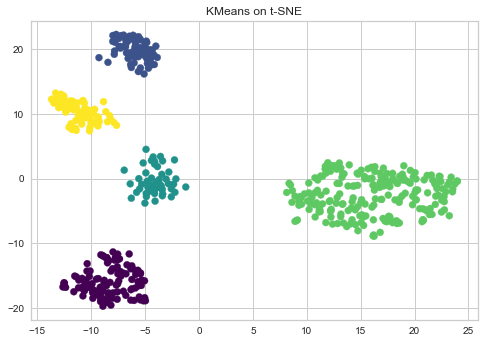

In [41]:
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans on t-SNE')

<b>MDS on cluster means.</b> Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [43]:
cmeans = np.zeros((5,X_log.shape[1]))
for ic in range(5):
    cmeans[i] = np.mean(X_log[np.where(kmeans.labels_==i)[0]],axis=0)

breaking at iteration 114 with stress 6079.000722754284
breaking at iteration 112 with stress 6342.539214001621
breaking at iteration 114 with stress 6079.000727928421
breaking at iteration 124 with stress 6079.000706330807


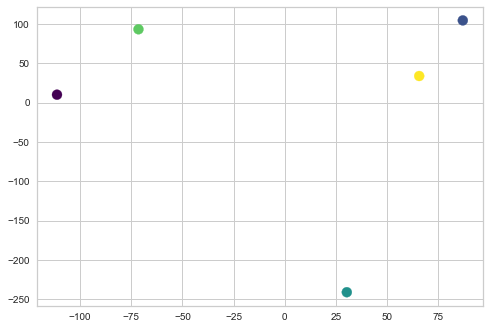

In [47]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100, cmap='viridis')
plt.show()

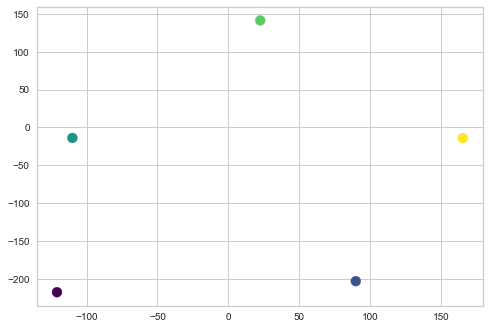

In [50]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100, cmap='viridis')
plt.show()

- The MDS and PCA plots confirm there are 3 groups of clusters, one group with 1 cluster mean and two groups with 2 cluster means each.
- The PCA and MDA plots show relatively accurate representation of distances, with one cluster means far away from the others, indicating a different type of cell.
- The T-SNE does not show any grouping of the cluster means, and place them at similar distances apart

> On the elbow plot (for Kmeans on principal components) it is clearly seen that the number of clusters should be 3 because there is the biggest drop of the curve at the point. PCA on two first principal components and MDS Plot show similar tendency: seeing data points after maximizing their correlation or minimizing distances we may conclude that there are probably three distinct clusters in the data. 

## UNSUPERVISED FEATURE SELECTION

Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will cluster the data, and then reating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set, and run it on the test set in the same folder.

In [51]:
X = np.load("X2.npy")
X = np.log2(X + 1)

In [53]:
%%timeit -n 1 -r 1
%%memit -r 1
pca, x_pc = do_pca(X, 50) 

peak memory: 2473.96 MiB, increment: 1537.10 MiB
31.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


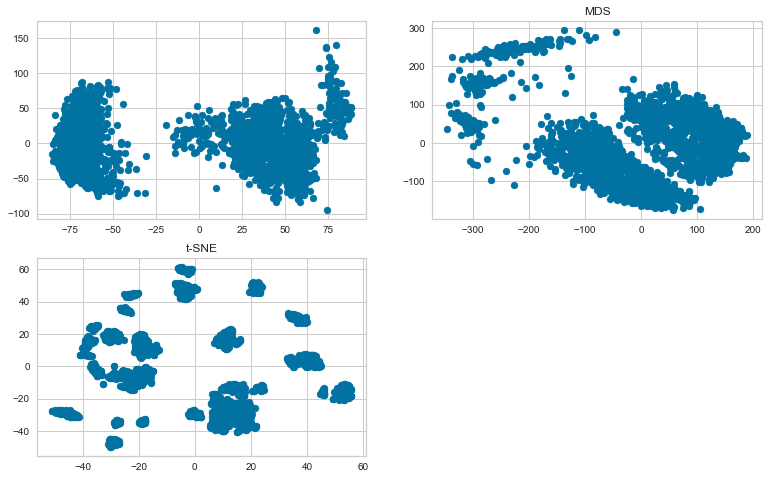

In [80]:
fig = plt.figure(figsize=(13, 8))
plt.subplot2grid((2, 2), (0, 0))
plt.scatter(x_pc[:, 1], x_pc[:, 2])

# mds=MDS(n_components=2).fit_transform(x_pc[:,0:50])
plt.subplot2grid((2, 2), (0, 1))
plt.scatter(mds[:, 0], mds[:, 1])
plt.title('MDS')

# z_tsne = TSNE(n_components=2, perplexity=40).fit_transform(x_pc)
plt.subplot2grid((2, 2), (1, 0))
plt.scatter(z_tsne[:,0],z_tsne[:,1])
plt.title('t-SNE')

plt.show()

<b>Three cell types.</b> Both PCA and MDS plots above show 3 distinct clusters,corresponding to inhibitory or excitatory neurons, and non-neuronal cells.   
             
However, by inspection of the t-SNE plot, we see that there are many sub-clusters of the groups. We guessed 30 clusters for the current exploration.

<b>Hierarchical clustering: Dendrogram<b>

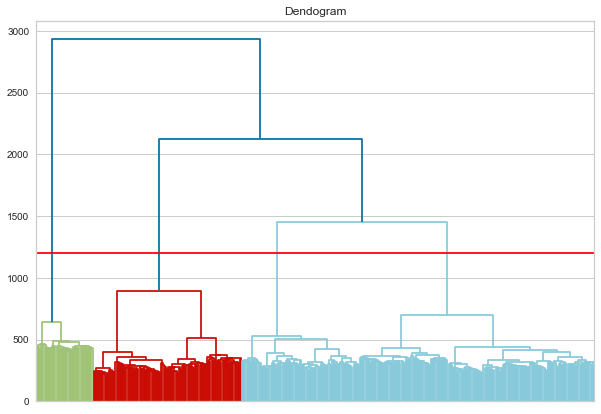

In [60]:
hierarchy.set_link_color_palette(None)
plt.figure(figsize=(10, 7))
plt.title("Dendogram")
dend = hierarchy.dendrogram(shc.linkage(x_log_pc, method='ward'))
plt.axhline(y=1200, color='red')
plt.xticks([])

plt.show()

Drawing a horizontal line through the longest distance we can define 3 clusters. But moving down the plot, the three groups are divided into multiple sub-groups. And, according to the scientists’ claim, the sub-groups belong to three types of cells in the brain: excitatory neurons, inhibitory neurons, or non-neuronal cells.

In [62]:
agg_model = AgglomerativeClustering(n_clusters=30,linkage="ward")
preds=agg_model.fit_predict(x_pc)

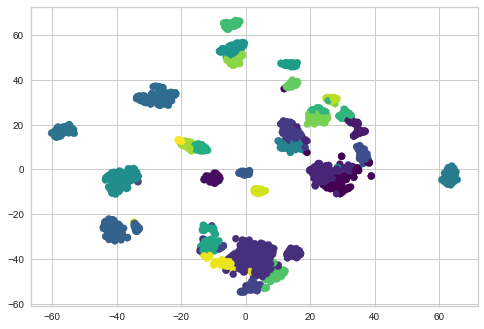

In [65]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(x_pc)
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=preds, cmap='viridis')
plt.title('t-SNE with 30 clusters')
plt.show()

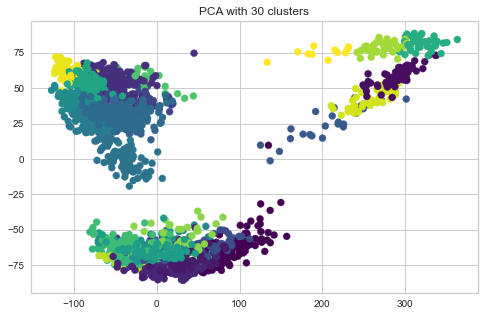

In [87]:
plt.figure(figsize=(8, 5))
plt.scatter(x_pc[:,0],x_pc[:,1],c=preds, cmap='viridis')
plt.title('PCA with 30 clusters')

plt.show()

<b>Cell sub-types.</b> Hierarchical clustering helped us to distinguish many sub-types of cell, so we use it for labeling the data. We create 30 cluster labels, and replot the PCA visualization with different colors showing the 30 different labels. This plot shows that these smaller clusters correspond to cell-subtypes that belong to the 3 bigger cell groups.

> Running t-SNE on PCs that explains 100% of data we can see that the points in clusters are quite scattered. So, for example, in the purple group there are some densely located points and some points that can be considered as their sub-types. The same for the rest two clusters.

### Clustering

We plot the mean silhouett score versus the number of clusters below, and use the number of clusters (29) for which the mean silhouett score is maximum. The T-SNE visualization also supports there are numerous clusters.

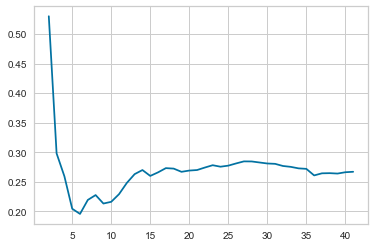

In [93]:
all_models = [i for i in range(45)]
for i in range(40):
    model = AgglomerativeClustering(n_clusters=i+2, linkage="ward")
    model.fit(x_pc)
    all_models[i] = model


scores = [silhouette_score(x_pc, all_models[i].labels_) for i in range(40)]    
plt.figure(figsize=(8, 5))
plt.plot([i+2 for i in range(40)], scores)
plt.title('Silhouett plot')

plt.show()

best_index = np.where(scores[5:] == max(scores[5:]))[0][0] + 5 + 2
print('Max score:', max(scores[5:], '\n# of clusters:', best_index)

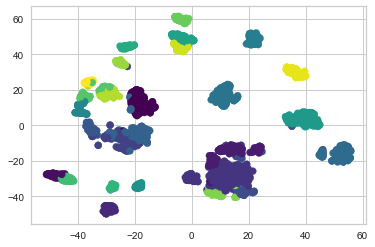

In [118]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=all_models[best_index].labels_, cmap='viridis')
plt.show()

In [119]:
#labeling data
labels = all_models[best_index].labels_

## LOGISTIC REGRESSION

The number of clusters k = 27 were chosen in accordance with prevous analysis. 

In [ ]:
# Standardize the data
# X_centered = X - np.mean(X,axis=0)
# locs_nz = np.where(np.std(X_centered,axis=0)>0)[0]
# X_standardized = X_centered
# X_standardized[:,locs_nz] /= np.std(X_centered[:,locs_nz],axis=0)

In [ ]:
# %%timeit -n 1 -r 1
# %%memit -r 1
# Logistic regression for feature selection with cross-validation. Takes about 7 min, 1.24 GB extra memory
# lr_sd = LogisticRegressionCV(penalty="l1",solver="liblinear",Cs=[.1,1,10],cv=3)
# lr_sd.fit(X_standardized, labels)

Training model on standardarized data is very memory- and time-consuming, so we'll use the original data:

In [121]:
%%timeit -n 1 -r 1
%%memit -r 1
# Logistic regression for feature selection with cross-validation. Takes about 7 min, 1.24 GB extra memory
lr = LogisticRegressionCV(penalty="l1",solver="liblinear",Cs=[.1,1,10],cv=3)
lr.fit(X, labels)

peak memory: 2863.55 MiB, increment: 1208.66 MiB
20min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [123]:
lr.score(X,labels)

1.0

### Feature selection and validation

Get top 100 features by taking features with the largest magnitude coefficients

In [186]:
coefs = np.sum(np.abs(lr.coef_), axis=0)
coefs = list(coefs)
top100 = np.sort(coefs)[-100:]
top100 = list(top100)

In [187]:
indecies = []
for coef in coefs:
    if coef in top100:
        indecies.append(coefs.index(coef))

Evaluation set

In [128]:
y_test, y_train = np.load('y_test.npy'), np.load('y_train.npy')
x_test, x_train = np.load('x_test.npy'), np.load('x_train.npy')

In [130]:
# Preprocessing
X_train = np.log2(x_train + 1)
X_test = np.log2(x_test + 1)

In [188]:
%%timeit -n 1 -r 1
%%memit -r 1
log_reg = LogisticRegressionCV(Cs=[0.01, 0.1, 1], penalty='l2', solver="liblinear", max_iter=5000, cv=5)
log_reg.fit(x_train[:, indecies], y_train)

peak memory: 2263.23 MiB, increment: 7.65 MiB
27.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [189]:
lr1_score = log_reg.score(x_test[:, indecies], y_test)

Comparison with highest-variance features

In [180]:
variances = np.var(X, axis=0)
v_features=np.argpartition(variances, -100)[-100:]
lr2 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100]).fit(x_train[:,v_features],y_train)
lr2_score = lr2.score(X_test[:,v_features],y_test)

Comparison with random selection

In [172]:
random_indecies = np.random.randint(1, 45768, 100) 
random = X[:, random_indecies]

In [183]:
lr3 = LogisticRegressionCV(penalty="l2",solver="liblinear",Cs=[.001,.1,1,5,10,50,100],cv=5).fit(X_train[:,random_indecies],y_train)
lr3_score = lr3.score(X_test[:,random_indecies],y_test)

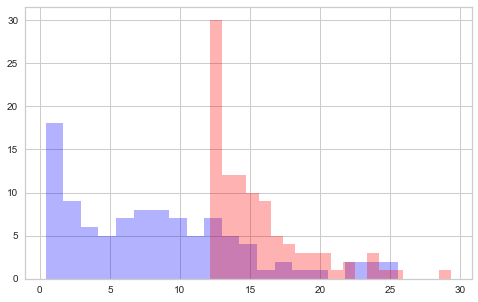

In [191]:
plt.figure(figsize=(8, 5))
plt.hist(variances[indexes],color="blue",alpha=0.3,bins=20)
plt.hist(variances[v_features],color="red",alpha=0.3,bins=20)
plt.show()

In [190]:
pd.DataFrame({'Features selection': ['Highest coef features', 'Highest variance features', 'Random features'], "Score": [lr1_score, lr2_score, lr3_score]})

,Features selection,Score
0,Highest coef features,0.850181
1,Highest variance features,0.604693
2,Random features,0.310469


> Logistic regression with 100 highest coeffs yeilds the best accuracy (0.85). Considering random genes we can get very poor result in clustering gene (less that 50%), which tells us that the <b>differences between cell types are not as evident as we assumed</b>. Only features with high variance and high LR coefs can perform good clustering.

 # t-SNE exploration (additional)

#### Changing number of PCs

In [148]:
x = PCA().fit_transform(X)

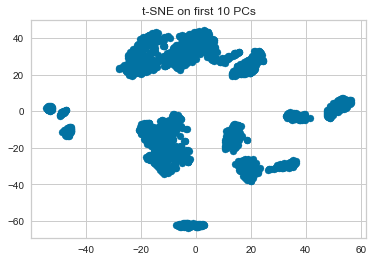

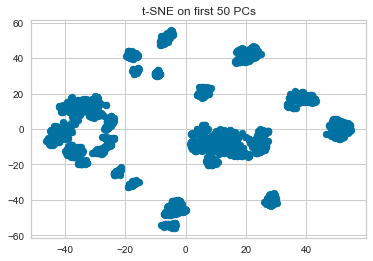

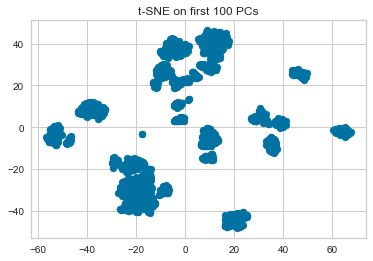

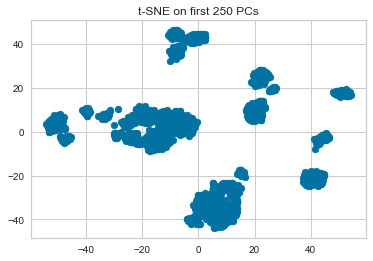

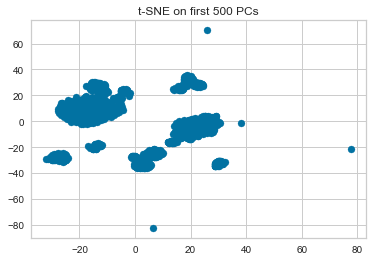

In [149]:
tsne = TSNE(perplexity=50)
for i in [10, 50, 100, 250, 500]:
    z_tsne = tsne.fit_transform(x[:, :i])
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
    plt.title('t-SNE on first {} PCs'.format(i))
    plt.show()

> t-SNE, implemented on 500 prinicple components includes noisy data (three dots on the top and on the right). 10 PCs also cannot be enough becase we loose too much data and the plot may not reperesent the actual picture although the clusters are quite visible. I cannot say that in this case clusters are getting clear with increasing number of PCs, so 50 components may be enough.

#### Perplexity tuning

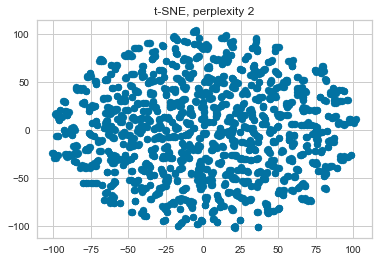

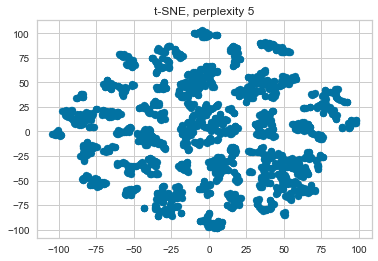

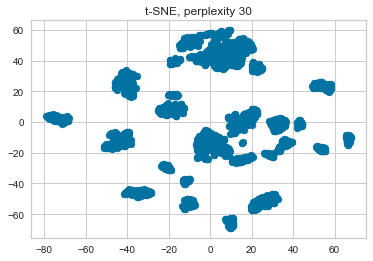

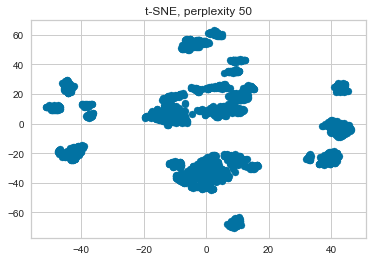

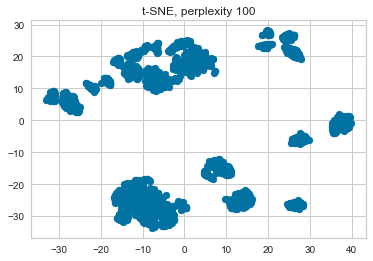

In [192]:
for i in [2, 5, 30, 50, 100]:
    tsne = TSNE(perplexity=i)
    z_tsne = tsne.fit_transform(x[:, :50])
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
    plt.title('t-SNE, perplexity {}'.format(i))
    plt.show()

> Perplexity 2 and 5 doesn’t make sense for the case because local variations dominate. With perplexity 30-100 the plots look pretty similar. However with increasing perplexity different clusters form new groups, that is perplexity 30 has scattered clusters, while perplexity 100 divide them into two or three groups. So, increasing the magnitude of the parameter lead to fewer clusters since there are more datapoints we consider to be neighbors.

In [193]:
kv = []
for i in [2, 5, 30, 50, 80, 100, 200]:
    tsne = TSNE(perplexity=i, random_state=1).fit(x[:, :50])
    kv.append(tsne.kl_divergence_)

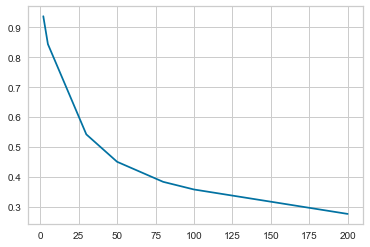

In [194]:
plt.plot([2, 5, 30, 50, 80, 100, 200], kv)

In [195]:
for i in range(1000, 7000, 1000):
    print(i)

1000
2000
3000
4000
5000
6000


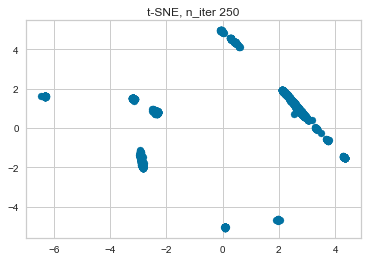

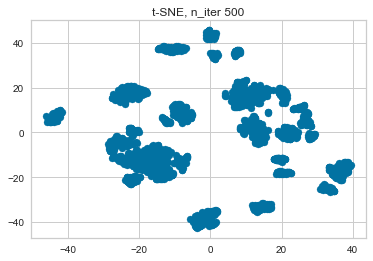

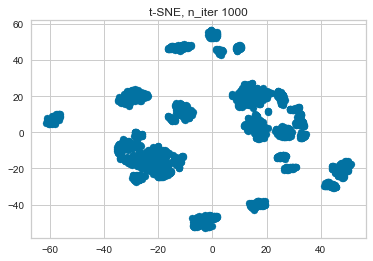

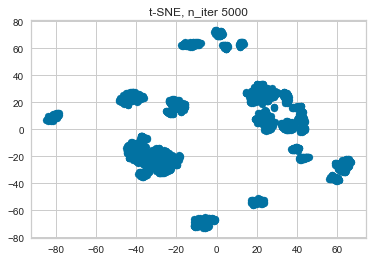

In [204]:
kv = []
for i in [250, 500, 1000, 5000]:
    tsne = TSNE(perplexity=50, random_state=1, n_iter=i).fit(x[:, :50])
    kv.append(tsne.kl_divergence_)
    z_tsne = tsne.fit_transform(x[:, :50])
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
    plt.title('t-SNE, n_iter {}'.format(i))
    plt.show()

> With larger number of iterations, the algorithm is more likely to converge. 250 iterations are not enough for the dataset; however, it is not necessary to run 5000 iterations because it looks like extra work and doesn’t really change the situation.